In [1]:
%%capture
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import numpy as np
import utils

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=6000)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Num GPUs Available:  1
2.15.0
1 Physical GPUs, 1 Logical GPUs


In [3]:
#set the necessary seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import datasets

### Breast cancer dataset

In [4]:
train_pairs_breast, val_pairs_breast, test_pairs_breast = utils.split_dataset(utils.create_list())
print(f"Number of training pairs: {len(train_pairs_breast)}")
print(f"Number of val pairs: {len(val_pairs_breast)}")
print(f"Number of test_pairs pairs: {len(test_pairs_breast)}")

Number of training pairs: 388
Number of val pairs: 129
Number of test_pairs pairs: 130


In [5]:
train_dataset_breast = utils.create_dataset(train_pairs_breast)
val_dataset_breast = utils.create_dataset(val_pairs_breast)
test_dataset_breast = utils.create_dataset(test_pairs_breast)

In [6]:
#batch the dataset and shuffle the training set
batch_size = 8

train_dataset_breast = train_dataset_breast.shuffle(buffer_size=len(train_pairs_breast)).batch(batch_size)
val_dataset_breast = val_dataset_breast.batch(batch_size)
test_dataset_breast = test_dataset_breast.batch(batch_size)

### Skin cancer dataset

In [7]:
train_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Training_Data", "ISIC-2017_Training_Part1_GroundTruth"))
val_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Validation_Data", "ISIC-2017_Validation_Part1_GroundTruth"))
test_dataset_skin = utils.create_dataset(utils.create_list_skin("ISIC-2017_Test_v2_Data", "ISIC-2017_Test_v2_Part1_GroundTruth"))

In [8]:
train_dataset_skin = train_dataset_skin.shuffle(buffer_size=2000).batch(batch_size)
val_dataset_skin = val_dataset_skin.batch(batch_size)
test_dataset_skin = test_dataset_skin.batch(batch_size)

### Brain cancer datatset

In [ ]:
train_pairs_brain, val_pairs_brain, test_pairs_brain = utils.split_dataset(utils.create_list_brain())
print(f"Number of training pairs: {len(train_pairs_brain)}")
print(f"Number of val pairs: {len(val_pairs_brain)}")
print(f"Number of test_pairs pairs: {len(test_pairs_brain)}")

In [ ]:
train_dataset_brain = utils.create_dataset(train_pairs_brain)
val_dataset_brain = utils.create_dataset(val_pairs_brain)
test_dataset_brain = utils.create_dataset(test_pairs_brain)

In [ ]:
train_dataset_brain = train_dataset_brain.shuffle(buffer_size=len(train_pairs_brain)).batch(batch_size)
val_dataset_brain = val_dataset_brain.batch(batch_size)
test_dataset_brain = test_dataset_brain.batch(batch_size)

## Architecture definition

In [ ]:
# from keras import layers, Model
#
# #function for encoder convolutional layers
# def convolutional_layer(input, num_filters, kernel_size=(3, 3), initializer = 'he_normal'):
#     regularizer = tf.keras.regularizers.l2(0.0001)
#
#     #first convolution
#     x = layers.Conv2D(filters=num_filters, kernel_size = kernel_size, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(input)
#     x = layers.LayerNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Dropout(0.3)(x)
#
#     #second convolution
#     x = layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding='same', kernel_initializer=initializer, kernel_regularizer=regularizer)(x)
#     x = layers.LayerNormalization()(x)
#     x = layers.Activation('relu')(x)
#     x = layers.Dropout(0.3)(x)
#
#     return x

In [9]:
from keras import layers, Model

#function for encoder convolutional layers
def convolutional_layer(input, num_filters, kernel_size=(3, 3), initializer = 'he_normal'):

    #first convolution
    x = layers.Conv2D(filters=num_filters, kernel_size = kernel_size, padding='same', kernel_initializer=initializer)(input)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    #second convolution
    x = layers.Conv2D(filters=num_filters, kernel_size=kernel_size, padding='same', kernel_initializer=initializer)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    return x

In [10]:
def basic_unet(input_size, num_filters=16):
    inputs = tf.keras.Input(shape=input_size)

    #encoder block
    first_conv = convolutional_layer(inputs, num_filters)
    first_layer = layers.MaxPool2D(pool_size=(2, 2))(first_conv)
    first_layer = layers.Dropout(0.1)(first_layer)

    second_conv = convolutional_layer(first_layer, num_filters * 2)
    second_layer = layers.MaxPool2D(pool_size=(2, 2))(second_conv)
    second_layer = layers.Dropout(0.1)(second_layer)

    third_conv = convolutional_layer(second_layer, num_filters * 4)
    third_layer = layers.MaxPool2D(pool_size=(2, 2))(third_conv)
    third_layer = layers.Dropout(0.1)(third_layer)

    fourth_conv = convolutional_layer(third_layer, num_filters * 8)
    fourth_layer = layers.MaxPool2D(pool_size=(2, 2))(fourth_conv)
    fourth_layer = layers.Dropout(0.1)(fourth_layer)

    fifth_conv = convolutional_layer(fourth_layer, num_filters * 16)

    #decoder block
    first_deconv = layers.Conv2DTranspose(num_filters * 8, kernel_size=(3, 3), strides=(2, 2), padding='same')(fifth_conv)
    sixth_layer = layers.concatenate([first_deconv, fourth_conv])
    sixth_layer = layers.Dropout(0.1)(sixth_layer)
    sixth_conv = convolutional_layer(sixth_layer, num_filters * 8)

    second_deconv = layers.Conv2DTranspose(num_filters * 4, kernel_size=(3, 3), strides=(2, 2), padding='same')(sixth_conv)
    seventh_layer = layers.concatenate([second_deconv, third_conv])
    seventh_layer = layers.Dropout(0.1)(seventh_layer)
    seventh_conv = convolutional_layer(seventh_layer, num_filters * 4)

    third_deconv = layers.Conv2DTranspose(num_filters * 2, kernel_size=(3, 3), strides=(2, 2), padding='same')(seventh_conv)
    eighth_layer = layers.concatenate([third_deconv, second_conv])
    eighth_layer = layers.Dropout(0.1)(eighth_layer)
    eighth_conv = convolutional_layer(eighth_layer, num_filters * 2)

    fourth_deconv = layers.Conv2DTranspose(num_filters, kernel_size=(3, 3), strides=(2, 2), padding='same')(eighth_conv)
    ninth_layer = layers.concatenate([fourth_deconv, first_conv])
    ninth_layer = layers.Dropout(0.1)(ninth_layer)
    ninth_conv = convolutional_layer(ninth_layer, num_filters)

    #output layer
    output = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid')(ninth_conv)

    unet = Model(inputs=inputs, outputs=output)

    return unet


In [11]:
dice_coefficient = utils.dice_coefficient
iou = utils.iou

In [12]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    return 1 - dice_coefficient(y_true, y_pred, smooth)

In [13]:
def bce_dice_loss(y_true, y_pred, smooth=1e-6):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred, smooth)

In [14]:
tf.keras.utils.get_custom_objects()["dice_loss"] = dice_loss
tf.keras.utils.get_custom_objects()["bce_dice_loss"] = bce_dice_loss

In [16]:
basic_unet = basic_unet(input_size=(256, 256, 3))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
lr_adapter = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_dice_coefficient", mode = "max", factor=0.1, patience=5, min_lr=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_dice_coefficient", mode= "max", patience=10, restore_best_weights=True)

In [17]:
basic_unet.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=["accuracy", dice_coefficient])

In [72]:
basic_unet.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_163 (Conv2D)         (None, 256, 256, 16)         448       ['input_10[0][0]']            
                                                                                                  
 batch_normalization_154 (B  (None, 256, 256, 16)         64        ['conv2d_163[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_154 (Activation  (None, 256, 256, 16)         0         ['batch_normalization_15

In [80]:
history = basic_unet.fit(train_dataset_breast, epochs=100, validation_data=val_dataset_breast, callbacks=[lr_adapter, early_stopping])

Epoch 1/100


2025-01-31 17:23:35.488138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/dropout_132/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


49/49 [==============================] - 21s 152ms/step - loss: 1.4516 - accuracy: 0.7179 - dice_coefficient: 0.1587 - val_loss: 1.5070 - val_accuracy: 0.7790 - val_dice_coefficient: 0.1374 - lr: 1.0000e-04
Epoch 2/100
49/49 [==============================] - 8s 137ms/step - loss: 1.3038 - accuracy: 0.8398 - dice_coefficient: 0.2137 - val_loss: 1.4546 - val_accuracy: 0.9078 - val_dice_coefficient: 0.1335 - lr: 1.0000e-04
Epoch 3/100
49/49 [==============================] - 8s 136ms/step - loss: 1.1698 - accuracy: 0.8892 - dice_coefficient: 0.2681 - val_loss: 1.3595 - val_accuracy: 0.9099 - val_dice_coefficient: 0.1258 - lr: 1.0000e-04
Epoch 4/100
49/49 [==============================] - 8s 136ms/step - loss: 1.0876 - accuracy: 0.9056 - dice_coefficient: 0.3027 - val_loss: 1.2780 - val_accuracy: 0.9123 - val_dice_coefficient: 0.1235 - lr: 1.0000e-04
Epoch 5/100
49/49 [==============================] - 7s 136ms/step - loss: 1.0291 - accuracy: 0.9103 - dice_coefficient: 0.3299 - val_loss:

In [84]:
basic_unet.save("basic_unet_first_version.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [82]:
test_loss, test_accuracy, test_dice = basic_unet.evaluate(test_dataset_breast)

17/17 [==============================] - 1s 44ms/step - loss: 0.6620 - accuracy: 0.9345 - dice_coefficient: 0.6132


1/1 [==============================] - 1s 617ms/step


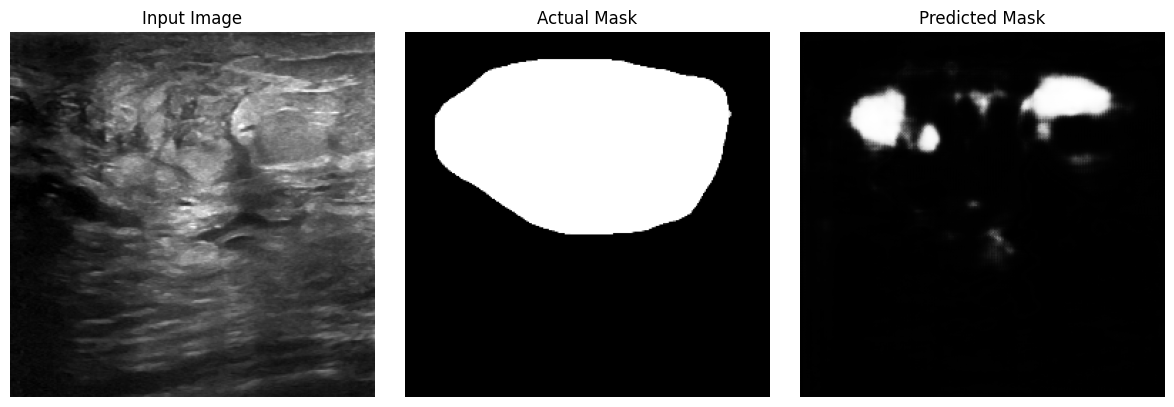

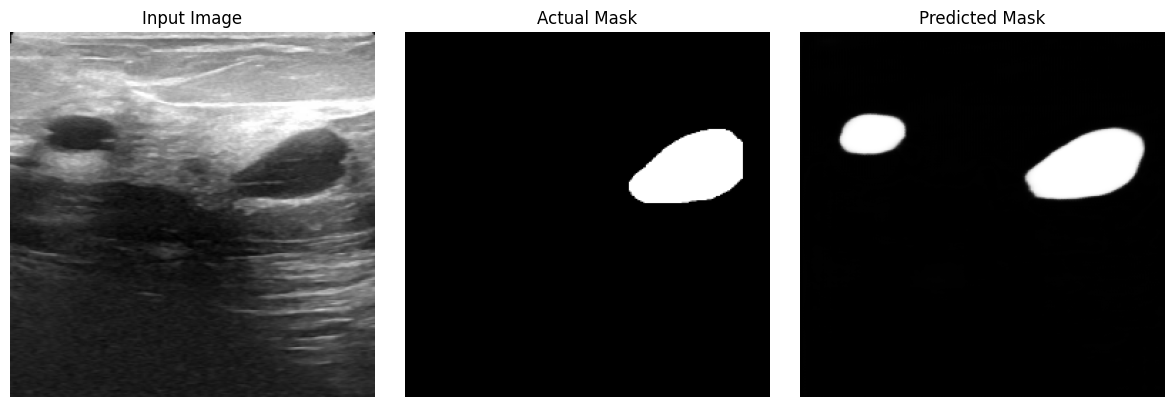

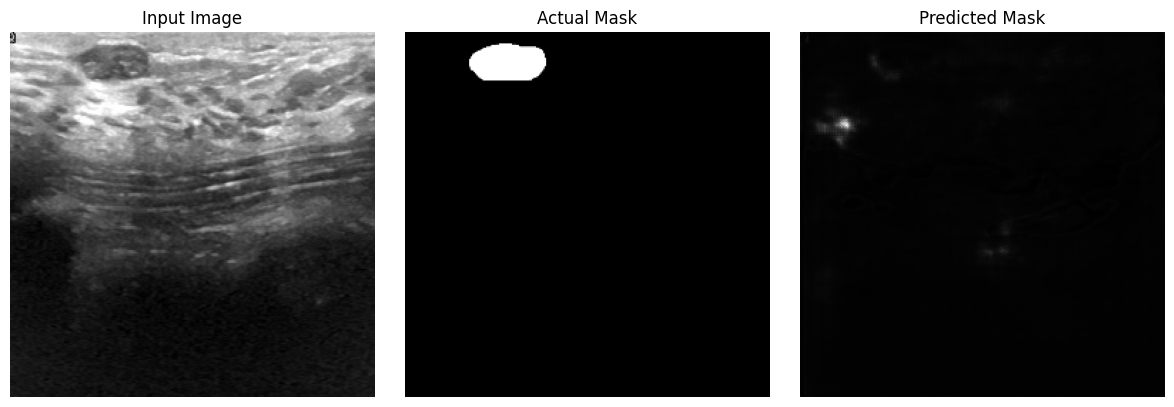

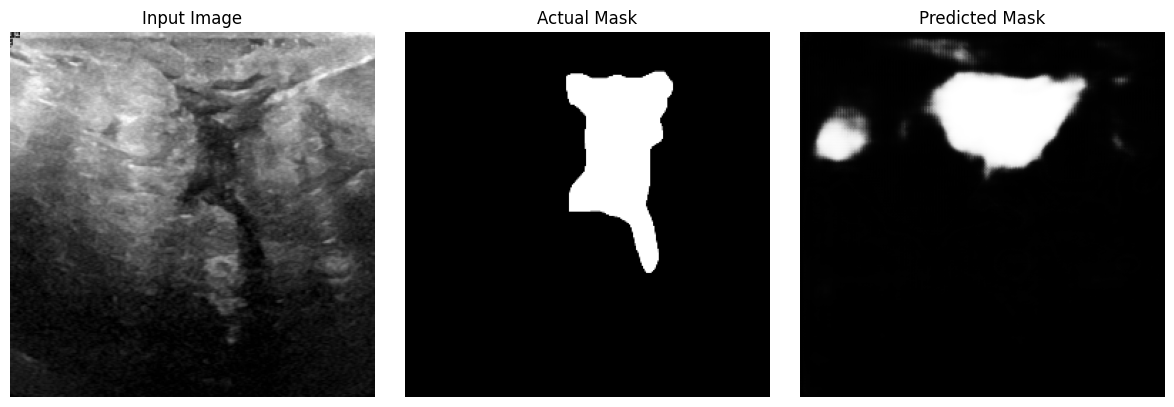

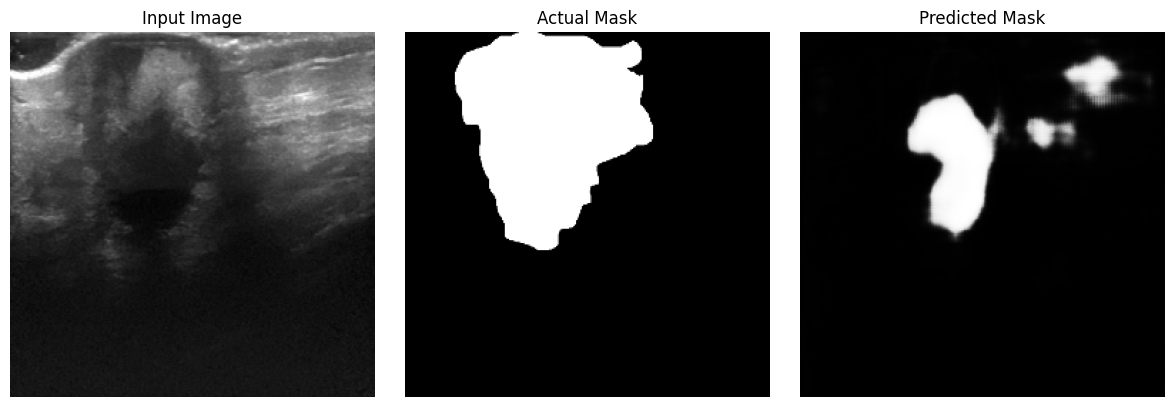

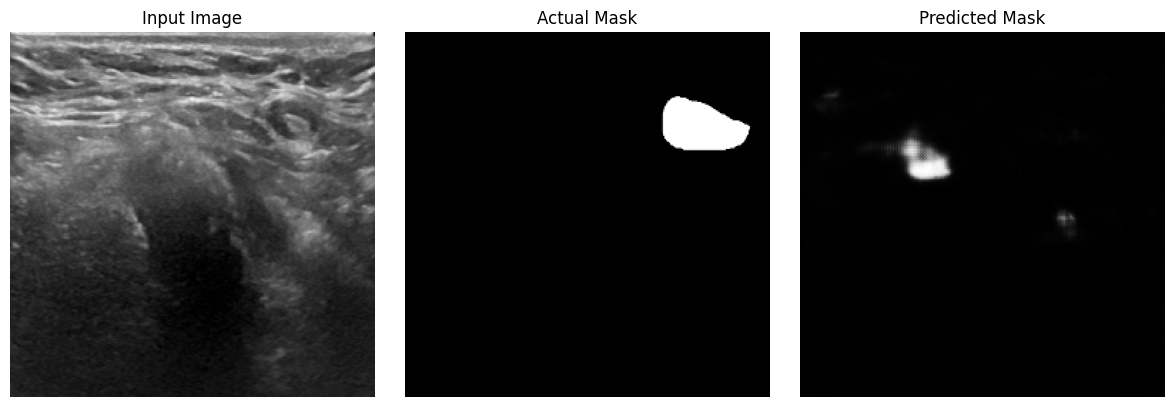

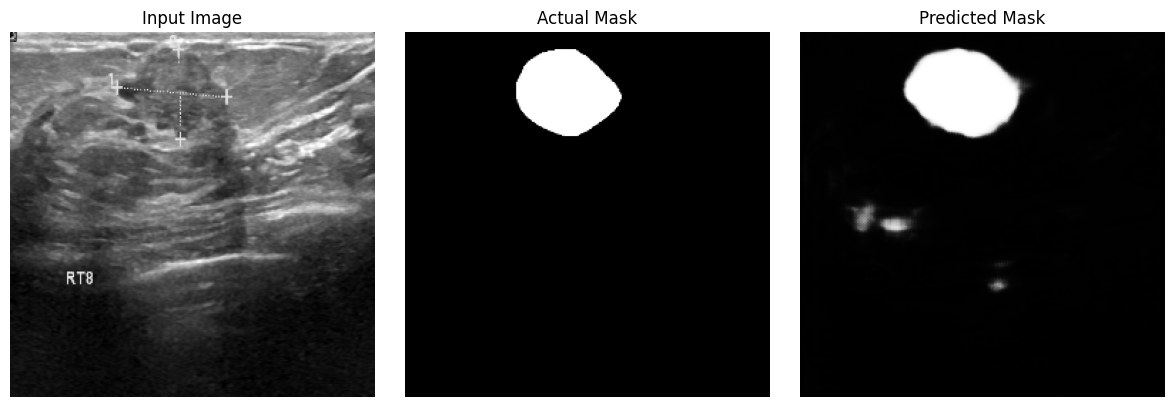

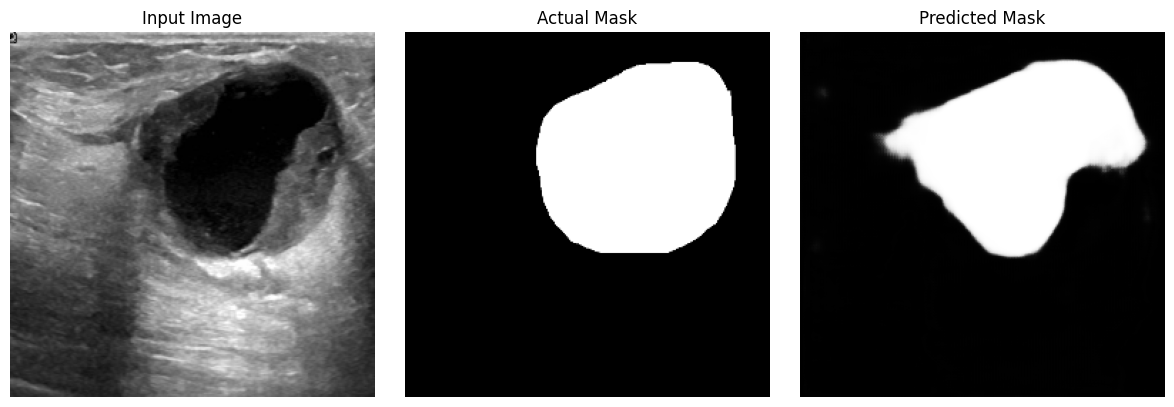

In [83]:
for i, (image, mask) in enumerate(test_dataset_breast.take(1)):
    predicted_mask = basic_unet.predict(image)
    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

In [ ]:
tf.keras.backend.clear_session()

### Fit on the skin cancer dataset

In [18]:
history = basic_unet.fit(train_dataset_skin, epochs=100, validation_data=val_dataset_skin, callbacks=[lr_adapter, early_stopping])

Epoch 1/100


I0000 00:00:1738346689.168917   21995 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 91s 158ms/step - loss: 1.0295 - accuracy: 0.8232 - dice_coefficient: 0.4587 - val_loss: 0.9431 - val_accuracy: 0.9012 - val_dice_coefficient: 0.4413 - lr: 1.0000e-04
Epoch 2/100
250/250 [==============================] - 62s 141ms/step - loss: 0.7493 - accuracy: 0.9243 - dice_coefficient: 0.5656 - val_loss: 0.8652 - val_accuracy: 0.9068 - val_dice_coefficient: 0.4843 - lr: 1.0000e-04
Epoch 3/100
250/250 [==============================] - 63s 142ms/step - loss: 0.6498 - accuracy: 0.9346 - dice_coefficient: 0.6123 - val_loss: 0.8176 - val_accuracy: 0.9015 - val_dice_coefficient: 0.5071 - lr: 1.0000e-04
Epoch 4/100
250/250 [==============================] - 63s 143ms/step - loss: 0.5876 - accuracy: 0.9371 - dice_coefficient: 0.6440 - val_loss: 0.6839 - val_accuracy: 0.9273 - val_dice_coefficient: 0.5535 - lr: 1.0000e-04
Epoch 5/100
250/250 [==============================] - 63s 143ms/step - loss: 0.5178 - accuracy: 0.9433 - dice_coefficient: 0.68

In [19]:
test_loss_skin, test_accuracy_skin, test_dice_skin = basic_unet.evaluate(test_dataset_skin)

75/75 [==============================] - 27s 361ms/step - loss: 0.5146 - accuracy: 0.9202 - dice_coefficient: 0.7787


1/1 [==============================] - 1s 644ms/step


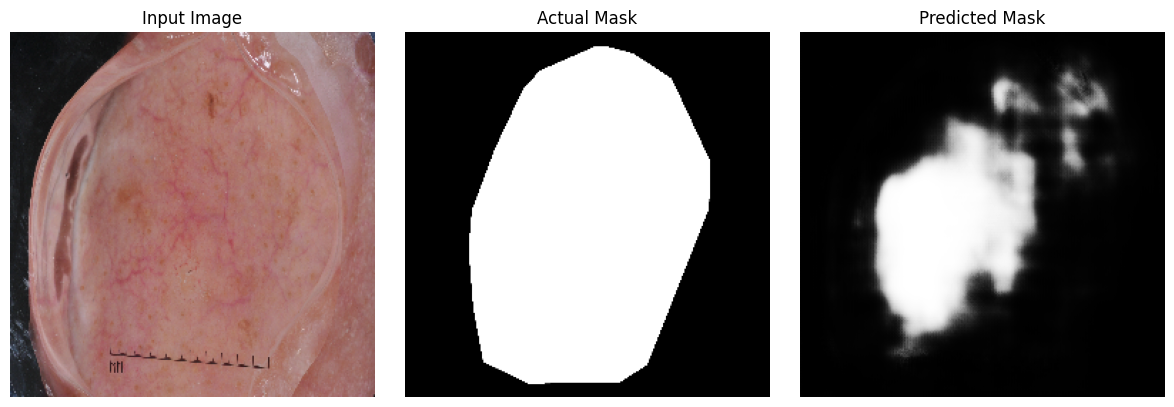

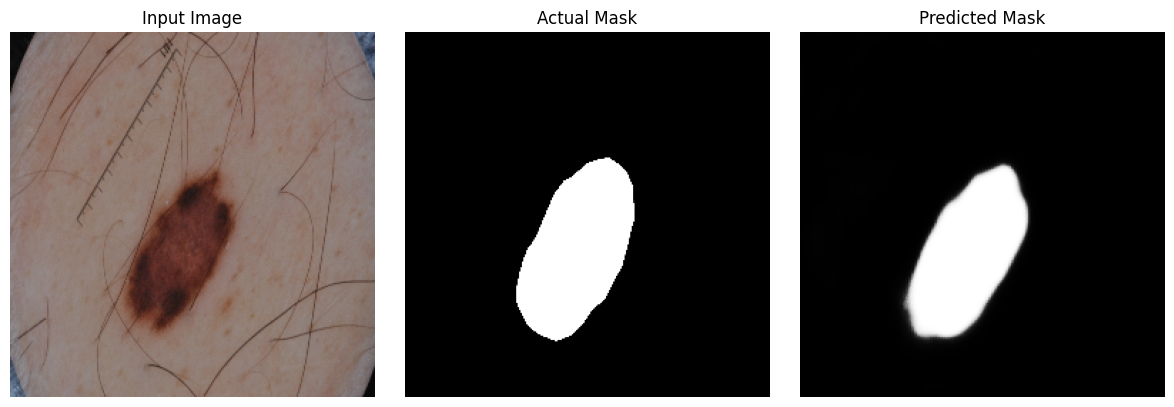

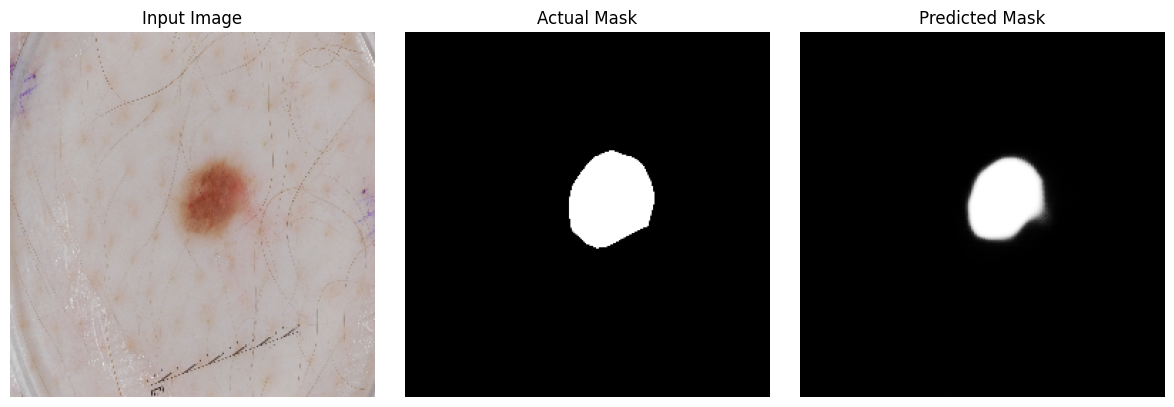

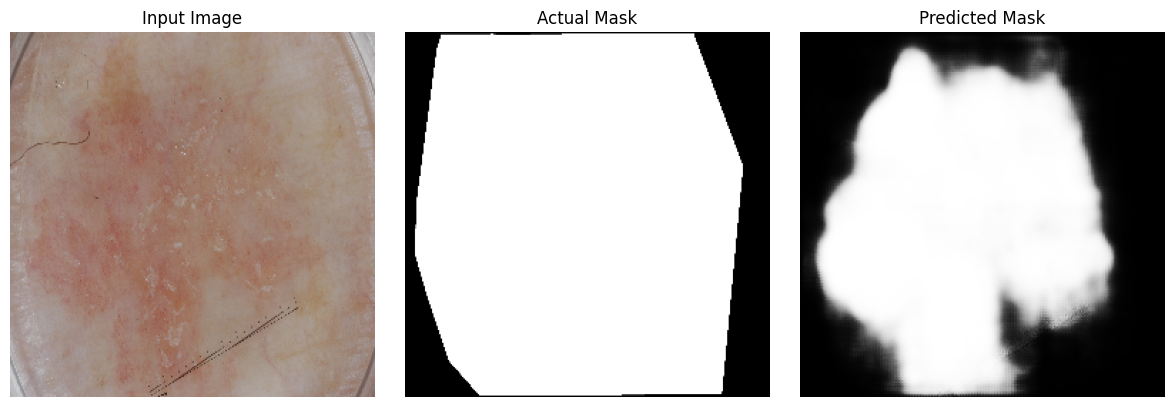

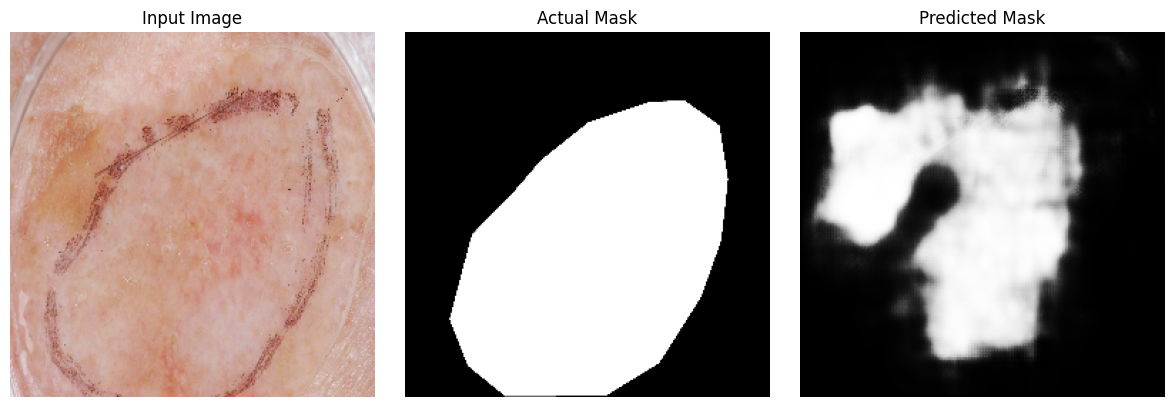

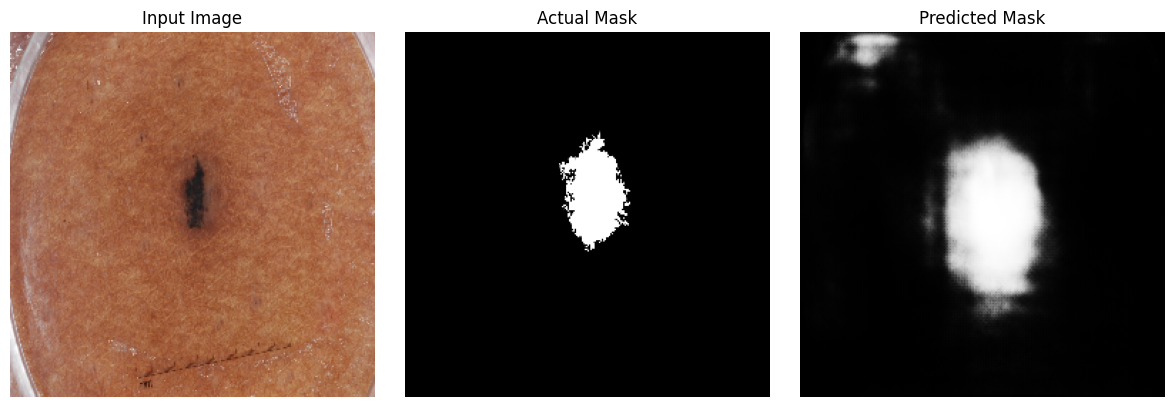

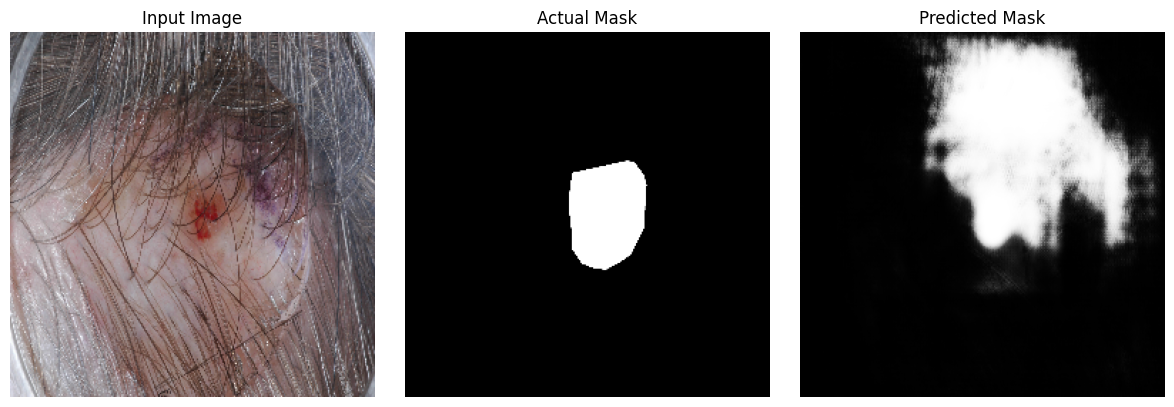

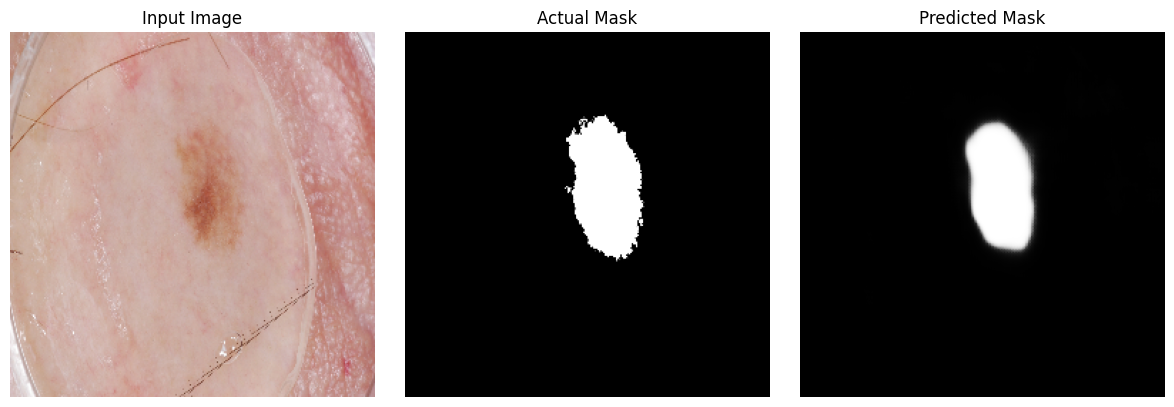

In [20]:
for i, (image, mask) in enumerate(test_dataset_skin.take(1)):
    predicted_mask = basic_unet.predict(image)
    for j in range(image.shape[0]):
        plt.figure(figsize=(12, 4))

        #display the input image
        plt.subplot(1, 3, 1)
        plt.imshow(image[j])
        plt.title("Input Image")
        plt.axis('off')

        # Display the actual mask
        plt.subplot(1, 3, 2)
        plt.imshow(mask[j], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        # Display the predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask[j], cmap='gray')  #
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.tight_layout()
        plt.show()